# Assignment 3 : Multi-label Image Classification

In [20]:
#!sh download_data.sh

In [21]:
#!sudo pip install sklearn

In [22]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from kaggle_submission import output_submission_csv
from classifier import Classifier
from voc_dataloader import VocDataset, VOC_CLASSES

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this assignment, you train a classifier to do multi-label classificaton on the PASCAL VOC 2007 dataset. The dataset has 20 different class which can appear in any given image. Your classifier will predict whether each class appears in an image. This task is slightly different from exclusive multiclass classification like the ImageNet competition where only a single most appropriate class is predicted for an image.

## Reading Pascal Data

### Loading Training Data

In the following cell we will load the training data and also apply some transforms to the data. Feel free to apply more [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) for data augmentation which can lead to better performance. 

In [23]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.RandomResizedCrop(227),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ])


In [24]:
ds_train = VocDataset('VOCdevkit_2007/VOC2007/','train',train_transform)

### Loading Validation Data

We will load the test data for the PASCAL VOC 2007 dataset. Do __NOT__ add data augmentation transforms to validation data.

In [25]:
# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize
        ])

In [26]:
ds_val = VocDataset('VOCdevkit_2007/VOC2007/','val',test_transform)

### Visualizing the Data

PASCAL VOC has bounding box annotations in addition to class labels. Use the following code to visualize some random examples and corresponding annotations from the train set. 

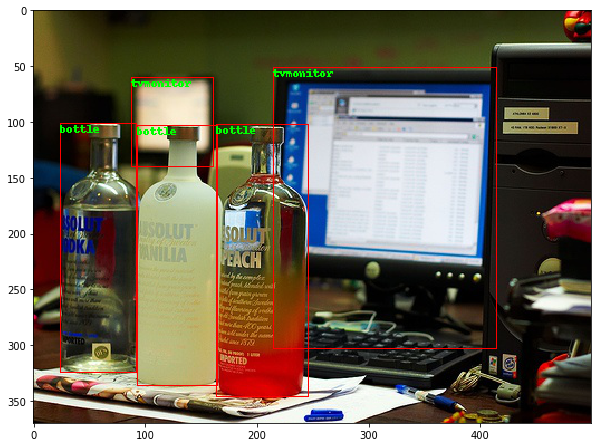

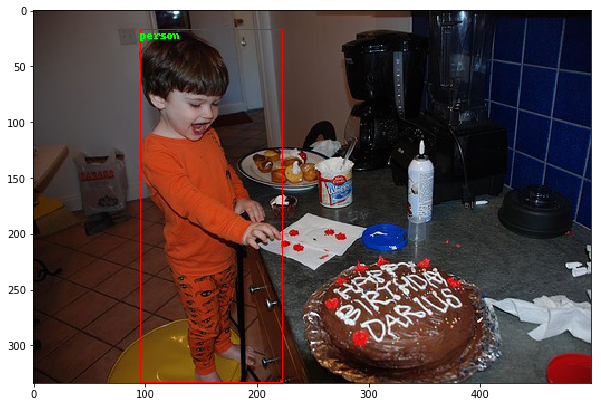

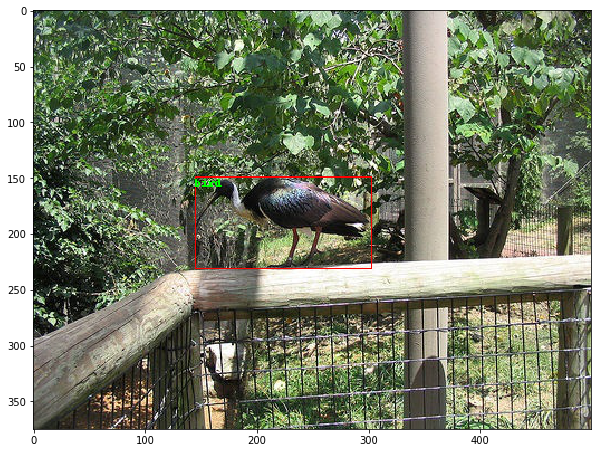

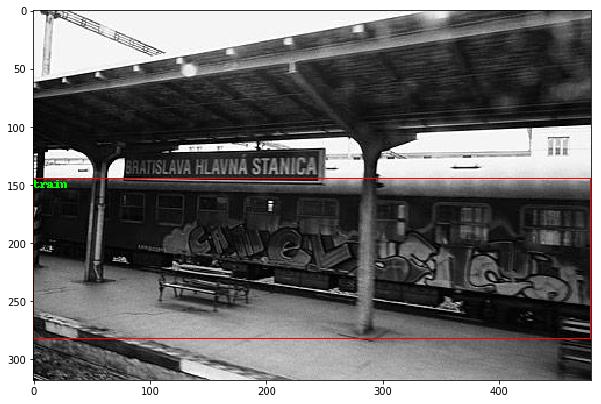

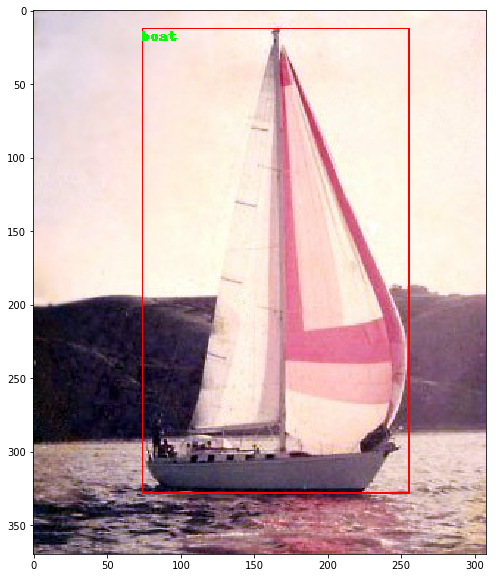

In [27]:
for i in range(5):
    idx = np.random.randint(0, len(ds_train.names)+1)
    _imgpath = os.path.join('VOCdevkit_2007/VOC2007/', 'JPEGImages', ds_train.names[idx]+'.jpg')
    img = Image.open(_imgpath).convert('RGB')
    draw = ImageDraw.Draw(img)
    for j in range(len(ds_train.box_indices[idx])):
        obj = ds_train.box_indices[idx][j]
        draw.rectangle(list(obj), outline=(255,0,0))
        draw.text(list(obj[0:2]), ds_train.classes[ds_train.label_order[idx][j]], fill=(0,255,0))
    plt.figure(figsize = (10,10))
    plt.imshow(np.array(img))

# Classification

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=30, 
                                               shuffle=True,
                                               num_workers=1)

In [30]:
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=30, 
                                               shuffle=True,
                                               num_workers=1)

In [31]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [32]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,21))
        y_score = np.zeros((0,21))
        for i, (images, labels, _) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss)
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        print('mAP: {0:.4f}'.format(mAP))
        print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

## Modifying the network 

The network you are given as is will allow you to reach around 0.15-0.2 mAP. To meet the benchmark for this assignment you will need to improve the network. There are a variety of different approaches you should try:

* Network architecture changes
    * Number of layers: try adding layers to make your network deeper
    * Batch normalization: adding batch norm between layers will likely give you a significant performance increase
    * Residual connections: as you increase the depth of your network, you will find that having residual connections like those in ResNet architectures will be helpful
* Optimizer: Instead of plain SGD, you may want to add a learning rate schedule, add momentum, or use one of the other optimizers you have learned about like Adam. Check the `torch.optim` package for other optimizers
* Data augmentation: You should use the `torchvision.transforms` module to try adding random resized crops and horizontal flips of the input data. Check `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip` for this
* Epochs: Once you have found a generally good hyperparameter setting try training for more epochs
* Loss function: You might want to add weighting to the `MultiLabelSoftMarginLoss` for classes that are less well represented or experiment with a different loss function



In [33]:
classifier = Classifier().to(device)
# You can can use this function to reload a network you have already saved previously
#classifier.load_state_dict(torch.load('voc_classifier.pth'))

In [34]:
criterion = nn.MultiLabelSoftMarginLoss()
#optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

In [35]:
# Training the Classifier
NUM_EPOCHS = 200
TEST_FREQUENCY = 10

for epoch in range(1, NUM_EPOCHS+1):
    if epoch == 100:
        optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)
    print("Starting epoch number " + str(epoch))
    train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    if(epoch%TEST_FREQUENCY==0):
        mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
        

Starting epoch number 1
Loss for Training on Epoch 1 is 0.25038424134254456
Starting epoch number 2
Loss for Training on Epoch 2 is 0.22546131908893585
Starting epoch number 3
Loss for Training on Epoch 3 is 0.22079363465309143
Starting epoch number 4
Loss for Training on Epoch 4 is 0.21614404022693634
Starting epoch number 5
Loss for Training on Epoch 5 is 0.21501779556274414
Starting epoch number 6
Loss for Training on Epoch 6 is 0.21029822528362274
Starting epoch number 7
Loss for Training on Epoch 7 is 0.21012337505817413
Starting epoch number 8
Loss for Training on Epoch 8 is 0.2074798196554184
Starting epoch number 9
Loss for Training on Epoch 9 is 0.20645663142204285
Starting epoch number 10
Loss for Training on Epoch 10 is 0.2052452266216278
-------  Class: aeroplane        AP:   0.4656  -------
-------  Class: bicycle          AP:   0.1001  -------
-------  Class: bird             AP:   0.1593  -------
-------  Class: boat             AP:   0.1782  -------
-------  Class: bott

Loss for Training on Epoch 43 is 0.1791076958179474
Starting epoch number 44
Loss for Training on Epoch 44 is 0.18026688694953918
Starting epoch number 45
Loss for Training on Epoch 45 is 0.1790032684803009
Starting epoch number 46
Loss for Training on Epoch 46 is 0.17878024280071259
Starting epoch number 47
Loss for Training on Epoch 47 is 0.17839744687080383
Starting epoch number 48
Loss for Training on Epoch 48 is 0.17848725616931915
Starting epoch number 49
Loss for Training on Epoch 49 is 0.17712238430976868
Starting epoch number 50
Loss for Training on Epoch 50 is 0.17832061648368835
-------  Class: aeroplane        AP:   0.6162  -------
-------  Class: bicycle          AP:   0.1358  -------
-------  Class: bird             AP:   0.2203  -------
-------  Class: boat             AP:   0.4452  -------
-------  Class: bottle           AP:   0.1401  -------
-------  Class: bus              AP:   0.2528  -------
-------  Class: car              AP:   0.6147  -------
-------  Class: ca

Loss for Training on Epoch 86 is 0.16647736728191376
Starting epoch number 87
Loss for Training on Epoch 87 is 0.164045512676239
Starting epoch number 88
Loss for Training on Epoch 88 is 0.16500146687030792
Starting epoch number 89
Loss for Training on Epoch 89 is 0.16312409937381744
Starting epoch number 90
Loss for Training on Epoch 90 is 0.16547182202339172
-------  Class: aeroplane        AP:   0.6505  -------
-------  Class: bicycle          AP:   0.1973  -------
-------  Class: bird             AP:   0.3596  -------
-------  Class: boat             AP:   0.4538  -------
-------  Class: bottle           AP:   0.1930  -------
-------  Class: bus              AP:   0.3324  -------
-------  Class: car              AP:   0.6177  -------
-------  Class: cat              AP:   0.3866  -------
-------  Class: chair            AP:   0.4961  -------
-------  Class: cow              AP:   0.1982  -------
-------  Class: diningtable      AP:   0.3474  -------
-------  Class: dog             

Loss for Training on Epoch 128 is 0.15351559221744537
Starting epoch number 129
Loss for Training on Epoch 129 is 0.15435409545898438
Starting epoch number 130
Loss for Training on Epoch 130 is 0.1536034792661667
-------  Class: aeroplane        AP:   0.6827  -------
-------  Class: bicycle          AP:   0.2053  -------
-------  Class: bird             AP:   0.3874  -------
-------  Class: boat             AP:   0.4777  -------
-------  Class: bottle           AP:   0.1893  -------
-------  Class: bus              AP:   0.3347  -------
-------  Class: car              AP:   0.6931  -------
-------  Class: cat              AP:   0.4137  -------
-------  Class: chair            AP:   0.5433  -------
-------  Class: cow              AP:   0.2241  -------
-------  Class: diningtable      AP:   0.4200  -------
-------  Class: dog              AP:   0.3289  -------
-------  Class: horse            AP:   0.5758  -------
-------  Class: motorbike        AP:   0.5353  -------
-------  Class: p

Loss for Training on Epoch 169 is 0.14947311580181122
Starting epoch number 170
Loss for Training on Epoch 170 is 0.1521836370229721
-------  Class: aeroplane        AP:   0.6749  -------
-------  Class: bicycle          AP:   0.2208  -------
-------  Class: bird             AP:   0.4178  -------
-------  Class: boat             AP:   0.4733  -------
-------  Class: bottle           AP:   0.1920  -------
-------  Class: bus              AP:   0.3368  -------
-------  Class: car              AP:   0.6961  -------
-------  Class: cat              AP:   0.4268  -------
-------  Class: chair            AP:   0.5379  -------
-------  Class: cow              AP:   0.2275  -------
-------  Class: diningtable      AP:   0.4101  -------
-------  Class: dog              AP:   0.3361  -------
-------  Class: horse            AP:   0.5827  -------
-------  Class: motorbike        AP:   0.5441  -------
-------  Class: person           AP:   0.8107  -------
-------  Class: pottedplant      AP:   0.1

In [36]:
# Save the clssifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './voc_classifier.pth')

# Evaluate on test set



In [37]:
ds_test = VocDataset('VOCdevkit_2007/VOC2007test/','test', test_transform)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=50, 
                                               shuffle=False,
                                               num_workers=1)

mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

-------  Class: aeroplane        AP:   0.6390  -------
-------  Class: bicycle          AP:   0.3146  -------
-------  Class: bird             AP:   0.3750  -------
-------  Class: boat             AP:   0.4965  -------
-------  Class: bottle           AP:   0.1677  -------
-------  Class: bus              AP:   0.3890  -------
-------  Class: car              AP:   0.7050  -------
-------  Class: cat              AP:   0.3938  -------
-------  Class: chair            AP:   0.4819  -------
-------  Class: cow              AP:   0.2215  -------
-------  Class: diningtable      AP:   0.3371  -------
-------  Class: dog              AP:   0.3447  -------
-------  Class: horse            AP:   0.6578  -------
-------  Class: motorbike        AP:   0.5455  -------
-------  Class: person           AP:   0.8093  -------
-------  Class: pottedplant      AP:   0.2146  -------
-------  Class: sheep            AP:   0.2632  -------
-------  Class: sofa             AP:   0.3488  -------
-------  C

In [38]:
output_submission_csv('my_solution.csv', test_aps)